In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools
import emcee

import symbolic_pofk.syren_new as syren_new
import symbolic_pofk.linear as linear
import pickle

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
sns.set(style="whitegrid", context="paper")

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# Load posterior ensembles for neural posterior estimators
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models/uniform_power/ensemble.pkl', 'rb') as f:
    posterior_ensemble_old = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models/tailed_power/ensemble.pkl', 'rb') as f:
    posterior_ensemble = pickle.load(f)

In [3]:
# Global constants
L, N = 1000, 64
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

# Original parameter ranges
param_1_range = (0.24, 0.40)   # Om
param_2_range = (0.61, 0.73)    # h
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Prior parameters
param_1_mean = (param_1_range[0] + param_1_range[1]) / 2  # Om mean
param_2_mean = (param_2_range[0] + param_2_range[1]) / 2  # h mean
param_1_std = 0.1 * (param_1_range[1] - param_1_range[0])   # Om std
param_2_std = 0.1 * (param_2_range[1] - param_2_range[0])   # h std

# simulator function
def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [4]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [5]:
def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [6]:
class SBIEvaluator:
   def __init__(self, param_names=['θ₁', 'θ₂']):
       self.param_names = param_names
   
   def c2st(self, X1, X2):
       """C2ST score - lower is better (0.5 = identical distributions)"""
       X = np.vstack([X1, X2])
       y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
       clf = LogisticRegression(max_iter=1000)
       y_pred = clf.fit(X_train, y_train).predict(X_test)
       return hamming_loss(y_test, y_pred)
   
   def tarp_score(self, samples, true_theta):
       """TARP calibration score - lower is better"""
       alpha_levels = np.linspace(0.05, 0.95, 19)
       empirical_coverage = []
       
       for alpha in alpha_levels:
           coverage = all(
               np.percentile(samples[:, j], 100*alpha/2) <= true_theta[j] <= 
               np.percentile(samples[:, j], 100*(1-alpha/2))
               for j in range(len(true_theta))
           )
           empirical_coverage.append(coverage)
       
       expected_coverage = 1 - alpha_levels
       return np.mean(np.abs(expected_coverage - empirical_coverage))
   
   def compare(self, samples_dict, true_theta):
       """Compare multiple methods"""
       results = {}
       methods = list(samples_dict.keys())
       
       for method, samples in samples_dict.items():
           results[method] = {
               'tarp': self.tarp_score(samples, true_theta),
               'mean': np.mean(samples, axis=0),
               'std': np.std(samples, axis=0),
               'c2st_vs_others': {}
           }
       
       # C2ST comparisons
       for i, method1 in enumerate(methods):
           for method2 in methods[i+1:]:
               score = self.c2st(samples_dict[method1], samples_dict[method2])
               results[method1]['c2st_vs_others'][method2] = score
               results[method2]['c2st_vs_others'][method1] = score
       
       return results
   
   def print_results(self, results, true_theta):
       """Print concise comparison"""
       methods = list(results.keys())
       
       print("Method Comparison")
       print("-" * 50)
       
       for method in methods:
           stats = results[method]
           print(f"\n{method}:")
           print(f"  TARP: {stats['tarp']:.4f}")
           for i, param in enumerate(self.param_names):
               print(f"  {param}: Mean={stats['mean'][i]:.3f}, Std={stats['std'][i]:.3f}")
           
           if stats['c2st_vs_others']:
               c2st_str = ", ".join([f"{k}={v:.3f}" for k, v in stats['c2st_vs_others'].items()])
               print(f"  C2ST: {c2st_str}")

In [ ]:
# Load test points from circle_grid dataset
mcmc_folder = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/circle_grid'
test_points_all = np.load(f'{mcmc_folder}/test_points.npy')

# Randomly select 3 test points
n_test_points = 3
random_indices = np.random.choice(len(test_points_all), n_test_points, replace=False)

print(f"Selected {n_test_points} random test points:")
print(f"Indices: {random_indices}")
print(f"\nTest points (Om, h):")
for idx in random_indices:
    print(f"  Index {idx}: {test_points_all[idx]}")

# Load corresponding MCMC samples
mcmc_samples_list = []
test_points_selected = []

for idx in random_indices:
    mcmc_samples = np.load(f'{mcmc_folder}/theta_{idx:04d}.npy')
    mcmc_samples_list.append(mcmc_samples)
    test_points_selected.append(test_points_all[idx])
    print(f"\nLoaded MCMC samples for index {idx}: shape {mcmc_samples.shape}")
    print(f"  Mean: {np.mean(mcmc_samples, axis=0)}")
    print(f"  Std:  {np.std(mcmc_samples, axis=0)}")

test_points_selected = np.array(test_points_selected)

Selected 3 random test points:
Indices: [375 422   9]

Test points (Om, h):
  Index 375: [0.36296523 0.62228228]
  Index 422: [0.38088917 0.71423857]
  Index 9: [0.31790943 0.68989044]

Loaded MCMC samples for index 375: shape (12000, 2)
  Mean: [0.35417554 0.62840379]
  Std:  [0.00595115 0.00422448]

Loaded MCMC samples for index 422: shape (12000, 2)
  Mean: [0.38145235 0.71375816]
  Std:  [0.0074257  0.00463478]

Loaded MCMC samples for index 9: shape (12000, 2)
  Mean: [0.33070428 0.68001886]
  Std:  [0.00585948 0.00455759]


In [8]:
# Generate observations for each test point
observations_list = []

for i, theta_true in enumerate(test_points_selected):
    print(f"\nTest point {i+1}/{n_test_points}: {theta_true}")
    
    # Generate observation
    x_obs = simulator(theta_true)
    
    # Apply log10 transform (matching training data)
    x_obs_log = np.log10(x_obs)
    
    # Handle NaN values
    mask = np.isnan(x_obs_log)
    if np.any(mask):
        assert np.any(~mask), f"NaN for test point {i} (theta={theta_true})"
        x_obs_log[mask] = np.nanmean(x_obs_log)
    
    observations_list.append(x_obs_log)
    print(f"  Observation shape: {x_obs_log.shape}")


Test point 1/3: [0.36296523 0.62228228]
  Observation shape: (31,)

Test point 2/3: [0.38088917 0.71423857]
  Observation shape: (31,)

Test point 3/3: [0.31790943 0.68989044]
  Observation shape: (31,)


In [9]:
# Sample from both neural ensembles
n_posterior_samples = 12000

uniform_npe_samples_list = []
tailed_npe_samples_list = []

print(f"Sampling {n_posterior_samples} posterior samples from both ensembles:")

for i, x_obs in enumerate(observations_list):
    # Sample from Uniform NPE
    print("  Sampling from Uniform NPE...")
    samples_uniform = posterior_ensemble_old.sample((n_posterior_samples,), x_obs).cpu().numpy()
    uniform_npe_samples_list.append(samples_uniform)
    
    # Sample from TailedNormal NPE
    print("  Sampling from TailedNormal NPE...")
    samples_tailed = posterior_ensemble.sample((n_posterior_samples,), x_obs).cpu().numpy()
    tailed_npe_samples_list.append(samples_tailed)

INFO:root:Sampling models with [1285, 1264, 1248, 1209, 1196, 1194, 1184, 1173, 1130, 1122] samples each.


Sampling 12000 posterior samples from both ensembles:
  Sampling from Uniform NPE...


Drawing 1285 posterior samples:   0%|          | 0/1285 [00:00<?, ?it/s]

Drawing 1285 posterior samples: 2000it [00:01, 1364.69it/s]                         
Drawing 1264 posterior samples: 2000it [00:00, 81205.49it/s]            
Drawing 1248 posterior samples: 2000it [00:00, 92745.09it/s]            
Drawing 1209 posterior samples: 2000it [00:00, 87258.63it/s]            
Drawing 1196 posterior samples: 2000it [00:00, 3898.57it/s]                          
Drawing 1194 posterior samples: 2000it [00:00, 92749.19it/s]            
Drawing 1184 posterior samples: 2000it [00:00, 44955.99it/s]            
Drawing 1173 posterior samples: 2000it [00:00, 63185.78it/s]            
Drawing 1130 posterior samples: 2000it [00:00, 98066.50it/s]            
Drawing 1122 posterior samples: 2000it [00:00, 97151.09it/s]            
INFO:root:Sampling models with [1880, 1516, 1169, 1100, 1099, 1096, 1078, 1042, 1029, 997] samples each.


  Sampling from TailedNormal NPE...


Drawing 1880 posterior samples: 2000it [00:00, 82562.60it/s]            
Drawing 1516 posterior samples: 2000it [00:00, 2034.77it/s]                          
Drawing 1169 posterior samples: 2000it [00:00, 99799.04it/s]            
Drawing 1100 posterior samples: 2000it [00:00, 62909.53it/s]            
Drawing 1099 posterior samples: 2000it [00:00, 59185.99it/s]            
Drawing 1096 posterior samples: 2000it [00:00, 56829.15it/s]            
Drawing 1078 posterior samples: 2000it [00:00, 56650.69it/s]            
Drawing 1042 posterior samples: 2000it [00:00, 77162.17it/s]            
Drawing 1029 posterior samples: 2000it [00:00, 58173.83it/s]            
Drawing 997 posterior samples: 100%|██████████| 997/997 [00:00<00:00, 60156.53it/s]
INFO:root:Sampling models with [1285, 1264, 1248, 1209, 1196, 1194, 1184, 1173, 1130, 1122] samples each.


  Sampling from Uniform NPE...


Drawing 1285 posterior samples: 2000it [00:00, 86430.60it/s]            
Drawing 1264 posterior samples: 2000it [00:00, 98640.77it/s]            
Drawing 1248 posterior samples: 2000it [00:00, 95963.03it/s]            
Drawing 1209 posterior samples: 2000it [00:00, 27096.12it/s]            
Drawing 1196 posterior samples: 2000it [00:00, 96591.76it/s]            
Drawing 1194 posterior samples: 2000it [00:00, 89443.19it/s]            
Drawing 1184 posterior samples: 2000it [00:00, 92475.17it/s]            
Drawing 1173 posterior samples: 2000it [00:00, 103517.05it/s]           
Drawing 1130 posterior samples: 2000it [00:00, 99451.18it/s]            
Drawing 1122 posterior samples: 2000it [00:00, 96232.74it/s]            
INFO:root:Sampling models with [1880, 1516, 1169, 1100, 1099, 1096, 1078, 1042, 1029, 997] samples each.


  Sampling from TailedNormal NPE...


Drawing 1880 posterior samples: 2000it [00:00, 81891.21it/s]            
Drawing 1516 posterior samples: 2000it [00:00, 54689.88it/s]            
Drawing 1169 posterior samples: 2000it [00:00, 97184.86it/s]            
Drawing 1100 posterior samples: 2000it [00:00, 63613.67it/s]            
Drawing 1099 posterior samples: 2000it [00:00, 62112.53it/s]            
Drawing 1096 posterior samples: 2000it [00:00, 64576.93it/s]            
Drawing 1078 posterior samples: 2000it [00:00, 62382.75it/s]            
Drawing 1042 posterior samples: 2000it [00:00, 80360.66it/s]            
Drawing 1029 posterior samples: 2000it [00:00, 60900.43it/s]            
Drawing 997 posterior samples: 100%|██████████| 997/997 [00:00<00:00, 62615.61it/s]
INFO:root:Sampling models with [1285, 1264, 1248, 1209, 1196, 1194, 1184, 1173, 1130, 1122] samples each.


  Sampling from Uniform NPE...


Drawing 1285 posterior samples: 2000it [00:00, 7355.14it/s]             
Drawing 1264 posterior samples: 2000it [00:00, 99477.13it/s]            
Drawing 1248 posterior samples: 2000it [00:00, 100623.85it/s]           
Drawing 1209 posterior samples: 2000it [00:00, 98397.79it/s]            
Drawing 1196 posterior samples: 2000it [00:00, 98370.09it/s]            
Drawing 1194 posterior samples: 2000it [00:00, 94037.42it/s]            
Drawing 1184 posterior samples: 2000it [00:00, 104119.65it/s]           
Drawing 1173 posterior samples: 2000it [00:00, 95111.09it/s]            
Drawing 1130 posterior samples: 2000it [00:00, 103146.65it/s]           
Drawing 1122 posterior samples: 2000it [00:00, 105076.95it/s]           
INFO:root:Sampling models with [1880, 1516, 1169, 1100, 1099, 1096, 1078, 1042, 1029, 997] samples each.


  Sampling from TailedNormal NPE...


Drawing 1880 posterior samples: 2000it [00:00, 84555.76it/s]            
Drawing 1516 posterior samples: 2000it [00:00, 68201.73it/s]            
Drawing 1169 posterior samples: 2000it [00:00, 114255.08it/s]           
Drawing 1100 posterior samples: 2000it [00:00, 41807.79it/s]            
Drawing 1099 posterior samples: 2000it [00:00, 56889.66it/s]            
Drawing 1096 posterior samples: 2000it [00:00, 70896.44it/s]            
Drawing 1078 posterior samples: 2000it [00:00, 65063.27it/s]            
Drawing 1042 posterior samples: 2000it [00:00, 80093.65it/s]            
Drawing 1029 posterior samples: 2000it [00:00, 64309.10it/s]            
Drawing 997 posterior samples: 100%|██████████| 997/997 [00:00<00:00, 40549.24it/s]


In [10]:
# Evaluate all test points using the SBIEvaluator
evaluator = SBIEvaluator(param_names=['Om', 'h'])

all_results = []

for i in range(n_test_points):
    print(f"\n{'='*70}")
    print(f"TEST POINT {i+1}/{n_test_points}")
    print(f"{'='*70}")
    print(f"True parameters: {test_points_selected[i]}")
    print(f"Index: {random_indices[i]}")
    
    # Prepare samples dictionary
    samples_dict = {
        'MCMC_Reference': mcmc_samples_list[i],
        'Uniform_NPE': uniform_npe_samples_list[i],
        'TailedNormal_NPE': tailed_npe_samples_list[i]
    }
    
    # Evaluate
    results = evaluator.compare(samples_dict, test_points_selected[i])
    all_results.append(results)
    
    # Print results
    evaluator.print_results(results, test_points_selected[i])


TEST POINT 1/3
True parameters: [0.36296523 0.62228228]
Index: 375
Method Comparison
--------------------------------------------------

MCMC_Reference:
  TARP: 0.3737
  Om: Mean=0.354, Std=0.006
  h: Mean=0.628, Std=0.004
  C2ST: Uniform_NPE=0.210, TailedNormal_NPE=0.244

Uniform_NPE:
  TARP: 0.5000
  Om: Mean=0.345, Std=0.008
  h: Mean=0.636, Std=0.006
  C2ST: MCMC_Reference=0.210, TailedNormal_NPE=0.481

TailedNormal_NPE:
  TARP: 0.4526
  Om: Mean=0.346, Std=0.010
  h: Mean=0.635, Std=0.007
  C2ST: MCMC_Reference=0.244, Uniform_NPE=0.481

TEST POINT 2/3
True parameters: [0.38088917 0.71423857]
Index: 422
Method Comparison
--------------------------------------------------

MCMC_Reference:
  TARP: 0.4105
  Om: Mean=0.381, Std=0.007
  h: Mean=0.714, Std=0.005
  C2ST: Uniform_NPE=0.413, TailedNormal_NPE=0.330

Uniform_NPE:
  TARP: 0.3421
  Om: Mean=0.380, Std=0.017
  h: Mean=0.714, Std=0.017
  C2ST: MCMC_Reference=0.413, TailedNormal_NPE=0.405

TailedNormal_NPE:
  TARP: 0.2684
  Om: M

Saved histogram plot: sci-2-dim-figures/mcmc_evaluation_histograms.png


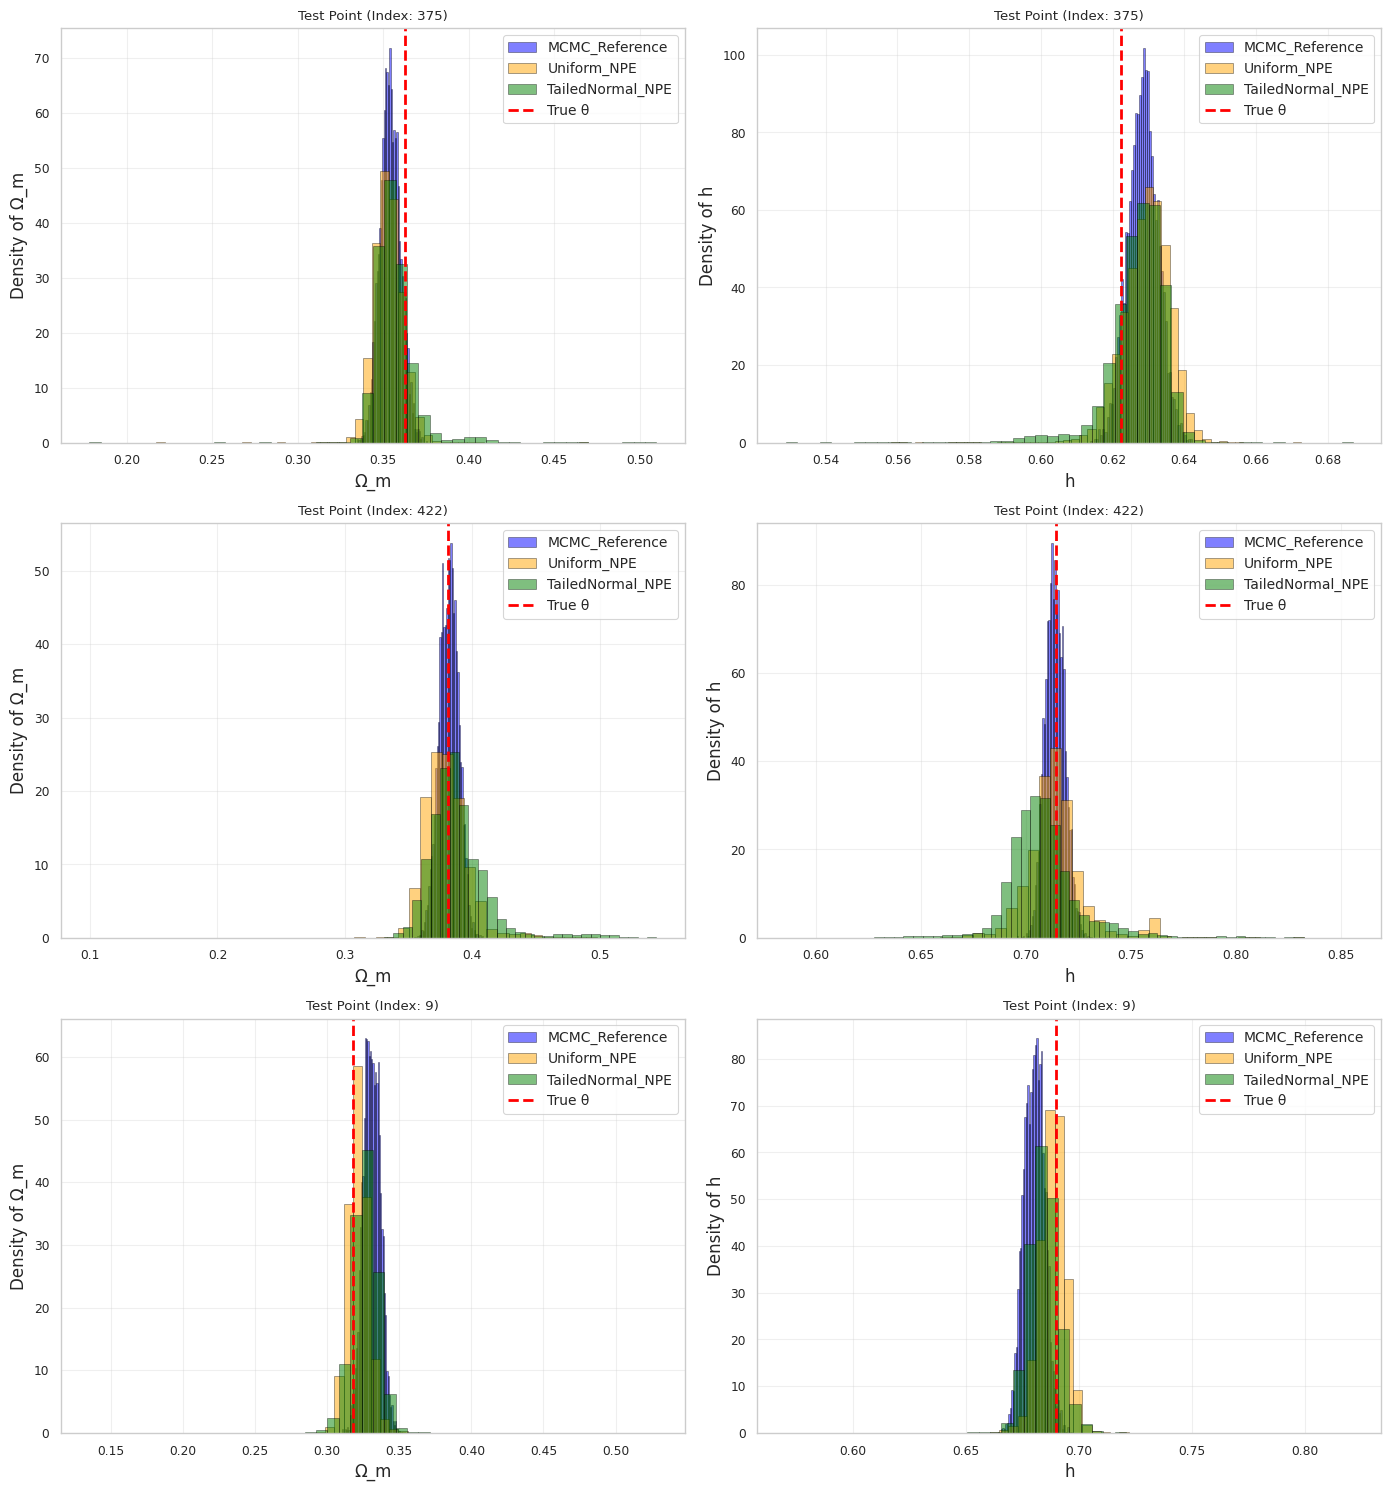

In [23]:
# Create visualization plots for all test points
fig, axes = plt.subplots(n_test_points, 2, figsize=(14, 5*n_test_points))

if n_test_points == 1:
    axes = axes.reshape(1, -1)

methods = ['MCMC_Reference', 'Uniform_NPE', 'TailedNormal_NPE']
colors = ['blue', 'orange', 'green']
param_names = ['Ω_m', 'h']

for test_idx in range(n_test_points):
    samples_list = [
        mcmc_samples_list[test_idx],
        uniform_npe_samples_list[test_idx],
        tailed_npe_samples_list[test_idx]
    ]
    
    for param_idx in range(2):
        ax = axes[test_idx, param_idx]
        
        # Plot histograms
        for method, samples, color in zip(methods, samples_list, colors):
            ax.hist(samples[:, param_idx], bins=50, alpha=0.5, density=True, 
                   label=method, color=color, edgecolor='black', linewidth=0.5)
        
        # Plot true value
        true_val = test_points_selected[test_idx, param_idx]
        ax.axvline(true_val, color='red', linestyle='--', linewidth=2, label='True θ')
        
        # Labels and title
        ax.set_xlabel(param_names[param_idx], fontsize=12)
        ax.set_ylabel(f'Density of {param_names[param_idx]}', fontsize=12)
        ax.set_title(f'Test Point (Index: {random_indices[test_idx]})')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = 'sci-2-dim-figures/mcmc_evaluation_histograms.png'
plt.savefig(filename, bbox_inches='tight', dpi=150)
print(f"Saved histogram plot: {filename}")
plt.show()

Evaluate all 475 test points from the circle grid against both neural ensemble models and MCMC ground truth.

In [20]:
class CircleEvaluator:
    def __init__(self, simulator, param_ranges, mcmc_folder):
        self.simulator = simulator
        self.param_ranges = param_ranges
        self.mcmc_folder = mcmc_folder
        self.prior_center = np.array([(low + high) / 2 for low, high in param_ranges])
        self.max_radius = min([(high - low) / 2 for low, high in param_ranges])

    def create_test_points(self, n_radii=20, n_angles=30):
        """Create test points on concentric circles"""
        test_points = [self.prior_center.copy()]
        radii = [0.0]

        for radius in np.linspace(0.2 * self.max_radius, 0.9 * self.max_radius, n_radii):
            for angle in np.linspace(0, 2*np.pi, n_angles, endpoint=False):
                x = self.prior_center[0] + radius * np.cos(angle)
                y = self.prior_center[1] + radius * np.sin(angle)

                if (self.param_ranges[0][0] <= x <= self.param_ranges[0][1] and 
                    self.param_ranges[1][0] <= y <= self.param_ranges[1][1]):
                    test_points.append([x, y])
                    radii.append(radius)

        return np.array(test_points), np.array(radii)

    def evaluate_all(self, posterior_dict, test_points, n_samples=10000):
        """Evaluate all posteriors including MCMC reference"""
        observations = []
        results = {'test_points': test_points}

        # Generate observations for all test points
        print("Generating observations...")
        for theta in tqdm(test_points, desc="Simulating"):
            x_obs = self.simulator(theta)
            # Apply log10 transform and handle NaNs
            x_obs_log = np.log10(x_obs)
            mask = np.isnan(x_obs_log)
            if np.any(mask):
                x_obs_log[mask] = np.nanmean(x_obs_log)
            observations.append(x_obs_log)

        results['observations'] = observations

        # Load MCMC reference samples
        print("\nLoading MCMC reference samples...")
        mcmc_samples = []
        for idx in tqdm(range(len(test_points)), desc="Loading MCMC"):
            mcmc_file = f'{self.mcmc_folder}/theta_{idx:04d}.npy'
            samples = np.load(mcmc_file)
            mcmc_samples.append(samples)
        results['MCMC_Reference'] = mcmc_samples

        # Sample from learned posteriors
        for name, posterior in posterior_dict.items():
            print(f"\nSampling from {name}...")
            samples = []
            for x_obs in tqdm(observations, desc=name):
                samples.append(posterior.sample((n_samples,), x_obs).cpu().numpy())
            results[name] = samples

        return results

    def c2st(self, X1, X2):
        """C2ST score"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss

        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        return hamming_loss(y_test, LogisticRegression(max_iter=1000).fit(X_train, y_train).predict(X_test))

    def compute_c2st_by_radius(self, results, radii):
        """Compute C2ST organized by radius"""
        methods = ['Uniform_NPE', 'TailedNormal_NPE', 'MCMC_Reference']
        unique_radii = np.unique(np.round(radii, 3))
        c2st_data = {}

        print("\nComputing C2ST scores by radius...")
        for radius in tqdm(unique_radii, desc="Radii"):
            indices = np.where(np.abs(radii - radius) < 1e-3)[0]
            c2st_data[f'{radius:.3f}'] = {}

            for i, m1 in enumerate(methods):
                for m2 in methods[i+1:]:
                    c2st_vals = [self.c2st(results[m1][idx], results[m2][idx]) for idx in indices]
                    c2st_data[f'{radius:.3f}'][f"{m1}_vs_{m2}"] = c2st_vals

        return c2st_data

    def plot_c2st_by_radius(self, c2st_data):
        """Plot average C2ST scores by radius"""
        comparisons = list(next(iter(c2st_data.values())).keys())
        radii = [float(r) for r in c2st_data.keys()]

        plt.figure(figsize=(12, 7))

        for comp in comparisons:
            avg_c2st = []
            std_c2st = []
            for radius_str in c2st_data.keys():
                vals = c2st_data[radius_str][comp]
                avg_c2st.append(np.mean(vals))
                std_c2st.append(np.std(vals))

            plt.plot(radii, avg_c2st, 'o-', label=comp, linewidth=2, markersize=8)
            plt.fill_between(radii, 
                           np.array(avg_c2st) - np.array(std_c2st), 
                           np.array(avg_c2st) + np.array(std_c2st), 
                           alpha=0.2)

        plt.axhline(0.5, color='gray', linestyle='--', linewidth=2, label='Ideal C2ST=0.5')
        plt.xlabel('Radius from Prior Center', fontsize=14)
        plt.ylabel('Average C2ST Score', fontsize=14)
        plt.title('C2ST Performance by Distance from Prior Center', fontsize=16, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        os.makedirs('sci-2-dim-figures', exist_ok=True)
        filename = 'sci-2-dim-figures/c2st_by_radius.png'
        plt.savefig(filename, bbox_inches='tight', dpi=150)
        print(f"\nSaved plot: {filename}")
        plt.show()

    def plot_c2st_tables(self, c2st_data):
        """Plot C2ST as colored tables"""
        sns.set(style="white")
        comparisons = list(next(iter(c2st_data.values())).keys())
        fig, axes = plt.subplots(len(comparisons), 1, figsize=(20, 10*len(comparisons)))
        if len(comparisons) == 1: 
            axes = [axes]

        for i, comp in enumerate(comparisons):
            radii = list(c2st_data.keys())
            max_pts = max(len(c2st_data[r][comp]) for r in radii)

            # Create data matrix
            data = np.full((len(radii), max_pts), np.nan)
            for j, r in enumerate(radii):
                vals = c2st_data[r][comp]
                data[j, :len(vals)] = vals

            # Plot
            im = axes[i].imshow(data, cmap='RdYlBu_r', vmin=0.3, vmax=0.6, aspect='auto')

            # Add text annotations (only for smaller matrices)
            if len(radii) < 30 and max_pts < 50:
                for j in range(len(radii)):
                    for k in range(max_pts):
                        if not np.isnan(data[j, k]):
                            color = 'white' if data[j, k] > 0.5 else 'black'
                            axes[i].text(k, j, f'{data[j, k]:.2f}', ha='center', va='center', 
                                       color=color, fontsize=6)

            axes[i].set_yticks(range(len(radii)))
            axes[i].set_yticklabels([f'r={r}' for r in radii], fontsize=8)
            axes[i].set_xlabel('Test Point within Radius', fontsize=12)
            axes[i].set_ylabel('Radius', fontsize=12)
            axes[i].set_title(comp.replace('_', ' '), fontsize=14)
            plt.colorbar(im, ax=axes[i], label='C2ST Score')

        plt.tight_layout()
        filename = 'sci-2-dim-figures/c2st_heatmap.png'
        plt.savefig(filename, bbox_inches='tight', dpi=150)
        print(f"Saved plot: {filename}")
        plt.show()

In [21]:
# Initialize CircleEvaluator and load test points
evaluator_circle = CircleEvaluator(
    simulator=simulator,
    param_ranges=param_ranges,
    mcmc_folder=mcmc_folder
)

# Load pre-generated test points and radii from MCMC folder
test_points_circle = np.load(f'{mcmc_folder}/test_points.npy')
radii_circle = np.load(f'{mcmc_folder}/radii.npy')

print(f"Loaded {len(test_points_circle)} test points from circle grid")
print(f"\nFirst 5 test points:")
for i in range(min(5, len(test_points_circle))):
    print(f"  {i}: {test_points_circle[i]} (radius: {radii_circle[i]:.4f})")

Loaded 475 test points from circle grid

First 5 test points:
  0: [0.32 0.67] (radius: 0.0000)
  1: [0.34 0.67] (radius: 0.0200)
  2: [0.33956295 0.67415823] (radius: 0.0200)
  3: [0.33827091 0.67813473] (radius: 0.0200)
  4: [0.33618034 0.68175571] (radius: 0.0200)


In [15]:
# Define posteriors to evaluate
posterior_dict_circle = {
    'Uniform_NPE': posterior_ensemble_old,
    'TailedNormal_NPE': posterior_ensemble
}

# Run evaluation on all test points

results_circle = evaluator_circle.evaluate_all(
    posterior_dict_circle, 
    test_points_circle, 
    n_samples=12000
)

Generating observations...


Simulating:   0%|          | 0/475 [00:00<?, ?it/s]/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
/tmp/ipykernel_2320819/705151682.py:36: RuntimeWarning: invalid value encountered in log10
  x_obs_log


Loading MCMC reference samples...


Loading MCMC: 100%|██████████| 475/475 [00:00<00:00, 882.17it/s]



Sampling from Uniform_NPE...


Uniform_NPE:   0%|          | 0/475 [00:00<?, ?it/s]INFO:root:Sampling models with [1285, 1264, 1248, 1209, 1196, 1194, 1184, 1173, 1130, 1122] samples each.
Drawing 1285 posterior samples: 2000it [00:01, 1448.83it/s]
Drawing 1264 posterior samples: 2000it [00:00, 3468.68it/s]                          
Drawing 1248 posterior samples: 2000it [00:00, 101337.39it/s]           
Drawing 1209 posterior samples: 2000it [00:00, 91269.81it/s]            
Drawing 1196 posterior samples: 2000it [00:00, 83922.17it/s]            
Drawing 1194 posterior samples: 2000it [00:00, 94354.74it/s]            
Drawing 1184 posterior samples: 2000it [00:00, 86455.54it/s]            
Drawing 1173 posterior samples: 2000it [00:00, 97165.72it/s]            
Drawing 1130 posterior samples: 2000it [00:00, 96297.92it/s]            
Drawing 1122 posterior samples: 2000it [00:00, 89450.82it/s]            
Uniform_NPE:   0%|          | 1/475 [00:02<17:01,  2.16s/it]INFO:root:Sampling models with [1285, 1264, 1248, 12


Sampling from TailedNormal_NPE...


TailedNormal_NPE:   0%|          | 0/475 [00:00<?, ?it/s]INFO:root:Sampling models with [1880, 1516, 1169, 1100, 1099, 1096, 1078, 1042, 1029, 997] samples each.
Drawing 1880 posterior samples: 2000it [00:02, 916.84it/s]
Drawing 1516 posterior samples: 2000it [00:02, 733.58it/s]
Drawing 1169 posterior samples: 2000it [00:00, 7020.08it/s]                          
Drawing 1100 posterior samples: 2000it [00:00, 65056.71it/s]            
Drawing 1099 posterior samples: 2000it [00:00, 65896.89it/s]            
Drawing 1096 posterior samples: 2000it [00:00, 65548.80it/s]            
Drawing 1078 posterior samples: 2000it [00:00, 66549.85it/s]            
Drawing 1042 posterior samples: 2000it [00:00, 85597.17it/s]            
Drawing 1029 posterior samples: 2000it [00:00, 67555.27it/s]            
TailedNormal_NPE:   0%|          | 1/475 [00:05<42:40,  5.40s/it]INFO:root:Sampling models with [1880, 1516, 1169, 1100, 1099, 1096, 1078, 1042, 1029, 997] samples each.
Drawing 1880 posterior sam


Computing C2ST scores by radius...


Radii: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]



Saved plot: sci-2-dim-figures/c2st_by_radius.png


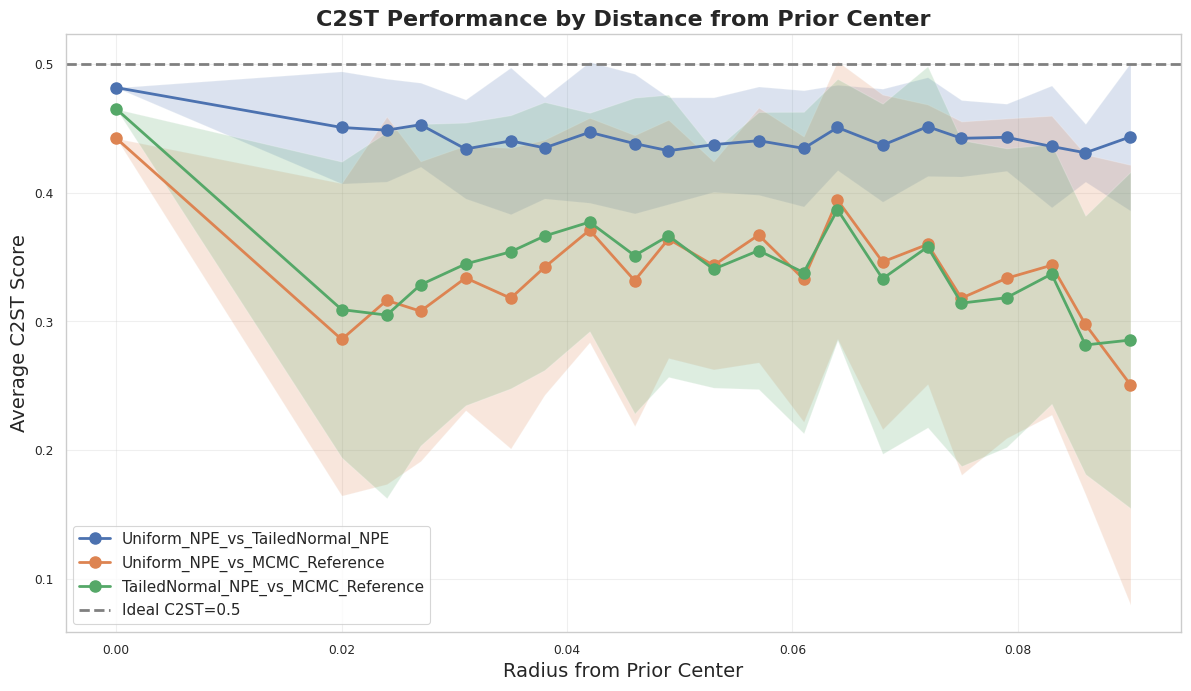

In [22]:
# Compute C2ST metrics organized by radius
c2st_by_radius = evaluator_circle.compute_c2st_by_radius(results_circle, radii_circle)

# Plot C2ST scores by radius
evaluator_circle.plot_c2st_by_radius(c2st_by_radius)